In [1]:
from cooltools import insulation, snipping
import pyBigWig

from dask.array.chunk import coarsen

from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture

import DNA_info
import matrix_manager as mm
%matplotlib inline

# Generating insulation tracks for fixed window size (in bp)

In [2]:
# res_window = {
#                 200000:[(50000,4), (25000,8), (10000,20)],
#                 500000:[(50000,10), (25000,20), (10000,50)],
#              }

# window_size = 200000
# ins_parameters = res_window[window_size]
# folder = f'{mm.analysis_path}insulation/window_{window_size}/'

# data = mm.Dataset()
# table = data.get_tables()

# for res, window_px in ins_parameters:
#     print(res, window_px)
#     table = mm.get_coolers(table, res=res)
    
#     savepath = f'{folder}{res}_{window_px}px/'
#     os.makedirs(savepath, exist_ok=True)
#     for i, row in table.iterrows():
#         name = row['lib_name']
#         cool = row[f'cooler_{res}']

#         print('\t', name)
#         ins_table = insulation.calculate_insulation_score(cool, window_size)
#         ins_table = insulation.find_boundaries(ins_table)

#         ins = np.log10(ins_table[f'boundary_strength_{window_size}'].values)
#         good_bins = ~np.isnan(ins)
#         a = ins[good_bins]
#         model = GaussianMixture(n_components=2, covariance_type='full')
#         model.fit(a.reshape(-1,1))    

#         mus = tuple(model.means_.reshape(-1))
#         true_peak_inds = np.argmax(mus)
#         full_labels = np.nan*np.ones(len(ins))
#         full_labels[good_bins] = model.predict(a.reshape(-1,1))

#         ins_table['category'] = full_labels
#         ins_table['category'] = ins_table['category'].apply(lambda x: np.nan if np.isnan(x) 
#                                                             else 'strong' if x == true_peak_inds 
#                                                             else 'weak')

#         ins_table.to_csv(f'{savepath}{name}.txt', sep='\t', header=True, index=False)

In [20]:
db = mm.Database('./metadata/U54_matrix_info')
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'celltype':'HFF',
                                                   'xlink':'DSG',
                                                   'enzyme':'DdeI',
                                                   'seq':'control',
                                                  })
table

,lib_name,seq,celltype,xlink,enzyme,cycle
29,U54-HFF-plate-DSG-DdeI-20160812-R1-T1__hg38,control,HFF,DSG,DdeI,NS


### Histograms of boundary scores for different (resolution, window_pixel) combinations

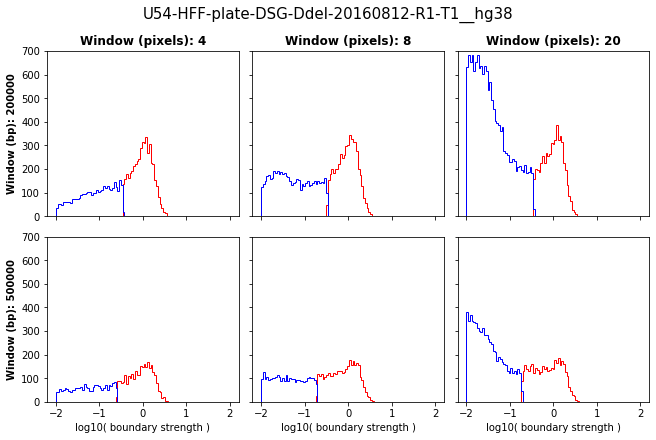

In [4]:
res_window = {
                200000:[(50000,4), (25000,8), (10000,20)],
                500000:[(50000,10), (25000,20), (10000,50)],
             }

dens = False
bins = np.linspace(-2,2,100)

# lib_name = 'U54-HFFc6-DSG-DdeI-R1-R2_hg38'
lib_name = 'U54-HFF-plate-DSG-DdeI-20160812-R1-T1__hg38'

fig, ax = plt.subplots(nrows=2, ncols=3,
                   sharey=True, sharex=True, constrained_layout=True,
                   figsize=(9,6)
                  )
fig.suptitle(lib_name, fontsize=15)

for i, window_size in enumerate([200000, 500000]):
    ax[i,0].set_ylabel(f'Window (bp): {window_size}', fontweight='bold')
#     ax[0,0].set_xlim([-3,3])
    ax[i,0].set_ylim([0,700])
    for j, (res, win_px) in enumerate(res_window[window_size]):
        
        df = db.get_insulations(table, 
                                subdir=f'insulation/window_{window_size}/{res}_{win_px}px/',
                                col_name='insulation',
                                )

        ins_table = df.iloc[0]['insulation']
            
        if 'HelaS3' in lib_name:
            mask = ins_table['chrom'].apply(lambda chrom: chrom in mm.hela_chroms)
            ins_table = ins_table.loc[mask]
            
        ins_table = ins_table.rename(columns={f'boundary_strength_{window_size}':'strength',
                                             f'log2_insulation_score_{window_size}':'log2_score'}).dropna()
    
        if not i:
            ax[i,j].set_title(f'Window (pixels): {win_px}', fontweight='bold', fontsize=12)
        else:
            ax[i,j].set_xlabel('log10( boundary strength )', fontsize=10)
        
        x = np.log10(ins_table.loc[ins_table['category']=='strong', 'strength'].values)
        _ = ax[i,j].hist(x, bins=bins, color='r', histtype='step', density=dens, label='strong')

        x = np.log10(ins_table.loc[ins_table['category']=='weak', 'strength'].values)
        _ = ax[i,j].hist(x, bins=bins, color='b', histtype='step', density=dens, label='weak')
# fig.savefig(f'/home/sameer/Dropbox (MIT)/{lib_name}.png')

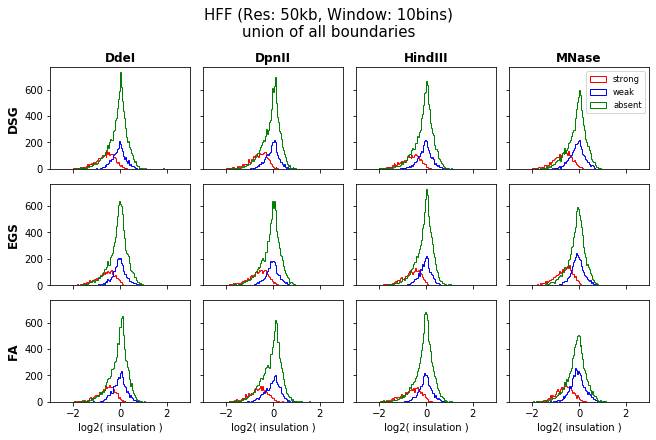

In [21]:
window_size = 500000
res, win_px = (50000,10)
assert window_size == res*win_px

celltype = 'HFF'
dens = False
filt = 'union'

table = db.get_tables()
table = mm.filter_data(table, filter_dict={'celltype':celltype,'seq':['control', '-']})
table = db.get_insulations(table, subdir=f'insulation/window_{window_size}/{res}_{win_px}px/')

master_df = None
for _, row in table.iterrows():
    name = row['lib_name']

    xlink = row['xlink']
    enz = row['enzyme']
    
    ins_table = row['insulation']
    ins_table = ins_table.rename(columns={f'boundary_strength_{window_size}':f'{xlink}-{enz}'}
                                )
    ins_table = ins_table[['chrom','start','end',f'{xlink}-{enz}']]
    if master_df is None:
        master_df = ins_table.copy()
    else:
        master_df = master_df.merge(ins_table, on=['chrom','start','end'], how='outer')

if celltype == 'HelaS3':
    mask = master_df['chrom'].apply(lambda chrom: chrom in mm.hela_chroms)
    master_df = master_df.loc[mask]

how = 'any'
if filt == 'union':
    how = 'all'
master_df = master_df.dropna(axis=0, how=how, subset=master_df.columns[3:])


ncols = table['enzyme'].unique().shape[0]
fig, ax = plt.subplots(nrows=table['xlink'].unique().shape[0], ncols=ncols,
                   sharey=True, sharex=True, constrained_layout=True,
                   figsize=(9,6)
                  )
ax[0,0].set_xlim([-3,3])
fig.suptitle(f'{celltype} (Res: {res//1000}kb, Window: {win_px}bins)\n{filt} of all boundaries', fontsize=15)

bins = np.linspace(-2,2,100)
for i, (xl, group) in enumerate(table.groupby('xlink')):
    group = group.reset_index(drop=True)
    ax[i,0].set_ylabel(xl, fontweight='bold', fontsize=12)
    
    for j, row in group.iterrows():
        name = row['lib_name']
        enz = row['enzyme']
        if not i:
            ax[i,j].set_title(enz, fontweight='bold', fontsize=12)
        elif i==2:
            ax[i,j].set_xlabel('log2( insulation )', fontsize=10)

        ins_table = row['insulation']
        ins_table = ins_table.rename(columns={f'log2_insulation_score_{window_size}':'log2_score'})
        ins_table['category'] = ins_table['category'].apply(lambda x: x if isinstance(x, str) else 'absent')
        ins_table = master_df.merge(ins_table, on=['chrom','start','end'], how='left')

        x = ins_table.loc[ins_table['category']=='strong', 'log2_score'].values
        _ = ax[i,j].hist(x, bins=bins, color='r', histtype='step', density=dens, label='strong')

        x = ins_table.loc[ins_table['category']=='weak', 'log2_score'].values
        _ = ax[i,j].hist(x, bins=bins, color='b', histtype='step', density=dens, label='weak')

        x = ins_table.loc[ins_table['category']=='absent', 'log2_score'].values
        _ = ax[i,j].hist(x, bins=bins, color='g', histtype='step', density=dens, label='absent')

ax[0,ncols-1].legend(loc='best', fontsize='small')

[1 1 4 ... 3 6 4]


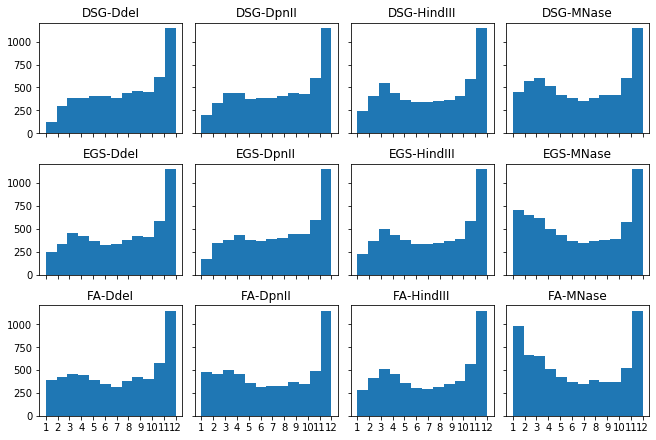

In [23]:
a = master_df[master_df.columns[3:]].apply(lambda ser: np.isfinite(ser.values).sum(), axis=1).values
fig, ax = plt.subplots(nrows=table['xlink'].unique().shape[0], ncols=ncols,
                           sharey=True, sharex=True, constrained_layout=True,
                           figsize=(9,6)
                          )
print(a)
ax[0,0].set_xticks(np.arange(0,13))
# ax[0,0].set_xticklabels(np.arange(1,13), fontsize=12)
xl_loc = {'DSG':0,'EGS':1,'FA':2}
enz_loc = {'DdeI':0,'DpnII':1,'HindIII':2,'MNase':3}
for col in master_df.columns[3:]:
    xl, enz = tuple(col.split('-'))
    b = master_df[col].apply(lambda x: np.isfinite(x)).values
    
    ax[xl_loc[xl], enz_loc[enz]].set_title(col)
    _ = ax[xl_loc[xl], enz_loc[enz]].hist(a[b], bins=12, density=False)


## Bryan style analysis

In [28]:
db = mm.Database('./metadata/U54_matrix_info')
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'celltype':'HFF','seq':'deep','enzyme':'double'})

res = 10000
table = db.get_coolers(table, res=res)
cool = table.iloc[0][f'cooler_{res}']

In [30]:
arm = DNA_info.get_chromosome_arms('hg38')[1]
folder = f'{db.analysis_path}insulation/HFF_double_chr1_10kb/'
# os.makedirs(folder, exist_ok=True)

# for win_px in np.arange(2, 101):
#     print('\n', win_px)
#     ins_table = insulation.calculate_insulation_score(cool, int(win_px*res), 
#                                                       chromosomes=[arm], verbose=True)
#     ins_table.to_csv(f'{folder}pixels_{win_px}.txt', sep='\t', header=True, index=False)

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [31]:
result = []
for win_px in np.arange(2, 101):
    df = pd.read_csv(f'{folder}pixels_{win_px}.txt', sep='\t')
    result.append(df[f'log2_insulation_score_{res*win_px}'].values)
    if win_px == 20:
        boundaries = insulation.find_boundaries(df)
result = np.vstack(tuple(result))
result

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [33]:
df = boundaries.dropna().copy()
df.loc[:, 'category'] = False
df.loc[df['boundary_strength_200000'].apply(lambda x: np.log10(x) >=-1), 'category'] = True

(-1, 300)

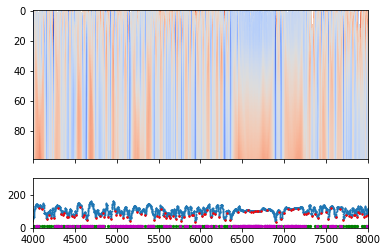

In [36]:
from scipy.signal import argrelmin

fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':[75,25]})
ax[0].imshow(result, aspect='auto', cmap='coolwarm', vmin=-2, vmax=2)

ax[0].set_xlim([4000, 8000])

sig = np.nansum(2**result, axis=0)

# ax[0].imshow(sig, aspect='auto', cmap='coolwarm', vmin=0, vmax=100)
# sig = scipy.ndimage.gaussian_filter1d(sig, 1)
ax[1].scatter(np.arange(len(sig)), sig, s=0.5)

inds = argrelmin(sig, order=10)
ax[1].scatter(inds, sig[inds], s=2, color='r')

bounds = df.loc[df['category']==True].index.values
for b in bounds:
    ax[1].scatter(b, 10, s=5, color='g')
    
bounds = df.loc[df['category']==False].index.values
for b in bounds:
    ax[1].scatter(b, 10, s=5, color='m')
    
ax[1].set_ylim([-1,300])

/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


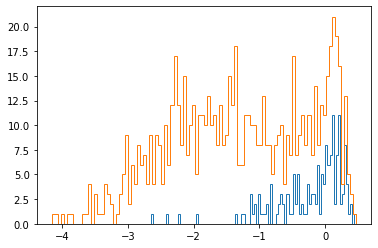

In [37]:
fig, ax = plt.subplots()

arr = np.log10(boundaries.iloc[inds]['boundary_strength_200000'].values)
_ = ax.hist(arr, bins=100, histtype='step')

arr = np.log10(boundaries['boundary_strength_200000'].values)
_ = ax.hist(arr, bins=100, histtype='step')


### Accessing data for deep tracks 

In [42]:
table = db.get_tables()

In [ ]:
for _, row in table.iterrows():
    name = row['lib_name']
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,7), sharex=True, sharey=False, constrained_layout=True)
    fig.suptitle(name)
    for i, res in enumerate([1000, 10000, 25000]):
        for j, win_px in enumerate([5, 10, 20]):
            ins = row[f'insulation_{res}_win{win_px}'].dropna()
            x = np.log10(ins[f'boundary_strength_{res*win_px}'].values)
            bins = np.linspace(x.min(), x.max(), num=100)
            if (res == 10000) and (win_px == 10):
                col = 'category'
            else:
                col = 'peak_cat'
            mask = ins[col].values == 'strong'
            ax[i,j].set_xlabel('log10 boundary strength')
            ax[i,j].set_title(f'Res: {res}, Window: {win_px}')
            _ = ax[i,j].hist(x[mask], bins=bins, color='r')
            _ = ax[i,j].hist(x[~mask], bins=bins, color='b')
            
#     fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/{name}_histogram.png')

#### Visualizing histograms

In [44]:
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'})
table = db.get_insulations(table, subdir=f'insulation/window_200000/10000_20px/')

U54-END4DN-FA-DSG-MNase-R1-R2_hg38
U54-END-FA-DpnII-R1-R2_hg38
U54-ESC4DN-DSG-DpnII-R1-R2_hg38
U54-H1ESC4DN-FA-DSG-MNase-R1-R2_hg38
U54-ESC4DN-FA-DpnII-R1-R2_hg38
U54-HFFc6-DSG-DdeI-R1-R2_hg38
U54-HFFc6-DSG-DpnII-R1-R2_hg38
U54-HFFc6-FA-DSG-MNase-R1-R3_hg38
U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38
U54-HFFc6-FA-DpnII-R1-R2_hg38
HelaS3-FA-DpnII-R1-R2_hg38


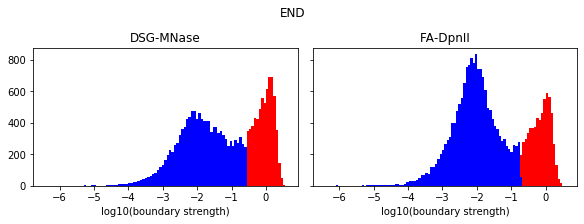

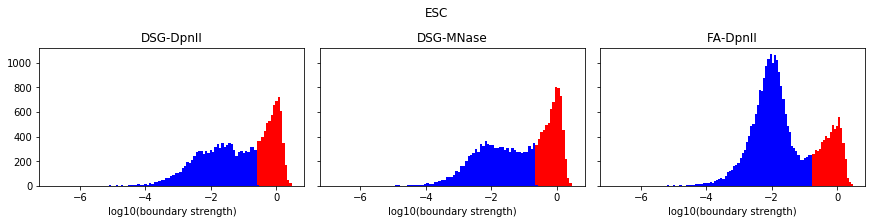

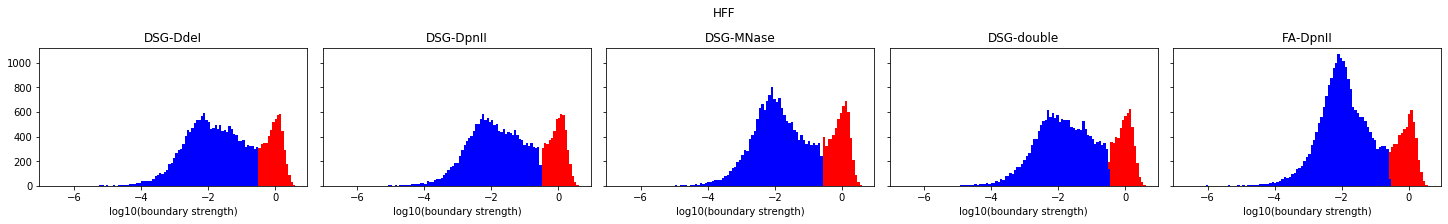

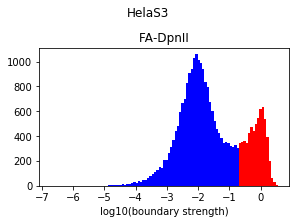

In [56]:
celltypes = table.celltype.unique()
for ct in celltypes:
    df = mm.filter_data(table, filter_dict={'celltype':ct}).reset_index(drop=True)
    
    fig, ax = plt.subplots(ncols=len(df), figsize=(4*len(df), 3), constrained_layout=True,
                           sharex=True, sharey=True)
    fig.suptitle(ct)
    
    for i, row in df.iterrows():
        print(row['lib_name'])
        xlink = row['xlink']
        enz = row['enzyme']
        
        ins = row['insulation'].dropna()
        x = np.log10(ins['boundary_strength_200000'].values)
        bins = np.linspace(x.min(), x.max(), num=100)
        mask = ins['category'].values == 'strong'
        
        if ct != 'HelaS3':
            ax[i].set_xlabel('log10(boundary strength)')
            ax[i].set_title(f'{xlink}-{enz}')
            _ = ax[i].hist(x[mask], bins=bins, color='r')
            _ = ax[i].hist(x[~mask], bins=bins, color='b')
        else:
            ax.set_xlabel('log10(boundary strength)')
            ax.set_title(f'{xlink}-{enz}')
            _ = ax.hist(x[mask], bins=bins, color='r')
            _ = ax.hist(x[~mask], bins=bins, color='b')

#     fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/{ct}_histogram.png')

#### Visualizing average stackup of peaks

In [58]:
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'celltype':'HFF', 'enzyme':'HindIII', 'seq':['-','control']}).sort_index()
table = db.get_insulations(table, f'insulation/window_200000/10000_20px/')
table = table.reset_index(drop=True)
table

,lib_name,seq,celltype,xlink,enzyme,cycle,insulation
0,U54-HFF-plate-DSG-HindIII-20160226-R1-T1__hg38,-,HFF,DSG,HindIII,NS,chrom start end is_bad_bin ...
1,U54-HFF-plate-EGS-HindIII-20190718-R2-T1__hg38,-,HFF,EGS,HindIII,NS,chrom start end is_bad_bin ...
2,U54-HFF-plate-FA-HindIIII-20160226-R2-T1__hg38,-,HFF,FA,HindIII,NS,chrom start end is_bad_bin ...


0
1
2


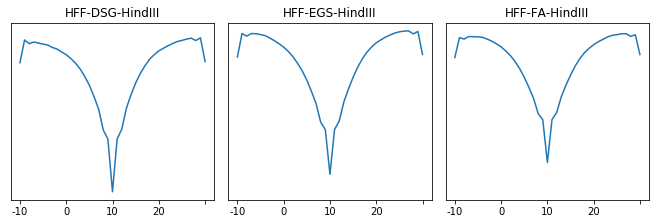

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=len(table), figsize=(3*len(table), 3), sharex=True, sharey=True, constrained_layout=True)

data_df = None
for i, row in table.iterrows():
    ct = row['celltype']
    enzyme = row['enzyme']
    xlink = row['xlink']
    ins = row['insulation']
    ins = ins.rename(columns={'boundary_strength_200000':'strength', 
                                'log2_insulation_score_200000':'insul'})
    ins = ins[['chrom','start','end','insul','strength','category']]
    peak_list = ins[ins.category.apply(lambda x: isinstance(x,str))]

    ax[i].set_title(f'{ct}-{xlink}-{enzyme}')
    signal = []

    for ind, _ in peak_list.iterrows():
        signal = np.append(signal, ins.loc[ind-20:ind+20, 'insul'].values)
            
    signal = np.nanmean(np.reshape(signal, (-1, 41)), axis=0)
    if data_df is None:
        data_df = pd.DataFrame({enzyme:signal})
    else:
        data_df = data_df.merge(pd.DataFrame({enzyme:signal}), left_index=True, right_index=True)
    ax[i].plot(signal)
    ax[i].set_yticks([])
    ax[i].set_xticklabels(['-20','-10','0','10','20'])
            
# data_df.to_csv(f'/net/wiz/home/sameer/Dropbox (MIT)/Research/U54_matrix/betul/insulation/{ct}_{enzyme}_data.txt', 
#                sep='\t', header=True, index=False)
# fig.savefig(f'/net/wiz/home/sameer/Dropbox (MIT)/Research/U54_matrix/betul/insulation/{ct}_{enzyme}.png')

## Comparing insulation peaks and eigenvectors

In [68]:
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'})
table = db.get_insulations(table, f'insulation/window_200000/10000_20px/')
table = db.get_eigendecomps(table, res=10000).dropna()
table

,lib_name,seq,celltype,xlink,enzyme,cycle,insulation,lams_10000,vectors_10000
0,U54-END4DN-FA-DSG-MNase-R1-R2_hg38,deep,END,DSG,MNase,NS,chrom start end is_bad_bin ...,eigval1 eig...,chrom start end gene_count ...
1,U54-END-FA-DpnII-R1-R2_hg38,deep,END,FA,DpnII,NS,chrom start end is_bad_bin ...,eigval1 eig...,chrom start end gene_count ...
3,U54-H1ESC4DN-FA-DSG-MNase-R1-R2_hg38,deep,ESC,DSG,MNase,NS,chrom start end is_bad_bin ...,eigval1 eig...,chrom start end gene_count ...
5,U54-HFFc6-DSG-DdeI-R1-R2_hg38,deep,HFF,DSG,DdeI,NS,chrom start end is_bad_bin ...,eigval1 eig...,chrom start end gene_count ...
6,U54-HFFc6-DSG-DpnII-R1-R2_hg38,deep,HFF,DSG,DpnII,NS,chrom start end is_bad_bin ...,eigval1 eig...,chrom start end gene_count ...
9,U54-HFFc6-FA-DpnII-R1-R2_hg38,deep,HFF,FA,DpnII,NS,chrom start end is_bad_bin ...,eigval1 eig...,chrom start end gene_count ...


### Histograms of eigenvector values at boundaries

/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameer/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= 

(-3, 3)

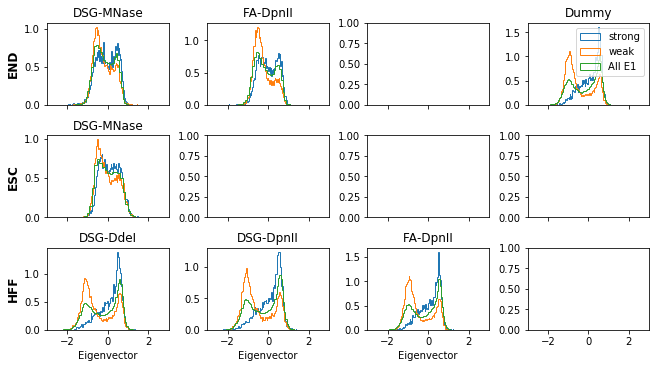

In [69]:
fig, ax_list = plt.subplots(nrows=3, ncols=4, figsize=(9,5), sharex=True, sharey=False, constrained_layout=True)
ind = 0
for ct, group in table.groupby('celltype'):

    for i, row in group.reset_index(drop=True).iterrows():

        name = f"{row['xlink']}-{row['enzyme']}"
        ins = row['insulation']
        vec = row['vectors_10000']
        
        merged = ins[['chrom','start','end','boundary_strength_200000','category']].merge(
                            vec[['chrom','start','end','E1']], on=['chrom','start','end'], how='inner'
                                                        )
        ax = ax_list[ind, i]
        if i == 0:
            ax.set_ylabel(ct, fontweight='bold', fontsize=12)
        ax.set_title(name)
        if ind == 2:
            ax.set_xlabel('Eigenvector')
        for cat, df in merged.groupby('category'):
            y = df['E1'].values
            _ = ax.hist(y, bins=100, histtype='step', label=cat, density=True)
        y = merged['E1'].values
        _ = ax.hist(y, bins=100, histtype='step', label='All E1', density=True)
    ind += 1
    
for cat, df in merged.groupby('category'):
    y = df['E1'].values
    _ = ax_list[0,3].hist(y, bins=100, histtype='step', label=cat, density=True) 
    
y = merged['E1'].values
_ = ax_list[0,3].hist(y, bins=100, histtype='step', label='All E1', density=True)
ax_list[0,3].legend()
ax_list[0,3].set_title('Dummy')
ax_list[0,3].set_xlim([-3, 3])

# fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/eig_hist_dense.png')

### Histograms of boundary strengths values in compartments

In [ ]:
fig, ax_list = plt.subplots(nrows=3, ncols=4, figsize=(9,5), sharex=True, sharey=False, constrained_layout=True)
ind = 0
for ct, group in table.groupby('celltype'):

    for i, row in group.reset_index(drop=True).iterrows():

        name = f"{row['xlink']}-{row['enzyme']}"
        ins = row['insulation_10000']
        vec = row['vectors_10000']
        
        merged = ins[['chrom','start','end','boundary_strength_100000','category']].merge(
                            vec[['chrom','start','end','E1']], on=['chrom','start','end'], how='inner'
                                                        )
        merged['comp'] = merged['E1'].apply(lambda x: 'A comp' if x>=0 else 'B comp')
        
        ax = ax_list[ind, i]
        if i == 0:
            ax.set_ylabel(ct, fontweight='bold', fontsize=12)
        ax.set_title(name)
        if ind == 2:
            ax.set_xlabel('log10(Boundary Strength)')
        for cat, df in merged.groupby('comp'):
            y = df['boundary_strength_100000'].values
            y = np.log10(y)
            _ = ax.hist(y, bins=100, histtype='step', label=cat, density=False)
            
        y = merged['boundary_strength_100000'].values
        y = np.log10(y)
        _ = ax.hist(y, bins=100, histtype='step', label='All boundaries', density=False)
    ind += 1
    
for cat, df in merged.groupby('comp'):
    y = df['boundary_strength_100000'].values
    y = np.log10(y)
    _ = ax_list[0,3].hist(y, bins=100, histtype='step', label=cat, density=False) 
    
y = merged['boundary_strength_100000'].values
y = np.log10(y)
_ = ax_list[0,3].hist(y, bins=100, histtype='step', label='All Boundaries', density=True)
ax_list[0,3].legend()
ax_list[0,3].set_title('Dummy')
# ax_list[0,3].set_xlim([-3, 3])

# fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/bound_hist.png')

In [ ]:
celltypes = table.celltype.unique()
for ct in celltypes:
    if ct =='HelaS3':
        continue
    df = table[table.celltype==ct].reset_index(drop=True)

    fig, ax = plt.subplots(nrows=2, ncols=len(df), figsize=(3*len(df), 4), constrained_layout=True,
                       sharex=True, sharey=True)
    fig.suptitle(f'Celltype: {ct}')
    
    for i, row in df.iterrows():
        print(row['lib_name'])
        name = f"{row['xlink']}-{row['enzyme']}"
        
        ins = row['insulation_10000']
        ins = ins.rename(columns={'boundary_strength_100000':'strength', 
                            'log2_insulation_score_100000':'insul'})
        vec = row['vectors_10000']
        
        merged = ins[['chrom','start','end','strength','insul']].merge(
                            vec[['chrom','start','end','E1']], on=['chrom','start','end'], how='inner'
                                                        ).dropna()
        merged['comp'] = merged['E1'].apply(lambda x: 'A comp' if x>=0 else 'B comp')
        ax[0, i].set_title(name)
        for j, comp in enumerate(['A comp', 'B comp']):
            ax[j, i].set_ylabel(comp)
            df1 = merged[merged['comp'] == comp]
            sig = []
            
            for ind, row1 in df1.iterrows():
                if np.isnan(row1['strength']):
                    continue
                    
                sig = np.append(sig, ins.loc[ind-20:ind+20, 'insul'].values)
            sig = np.nanmean(np.reshape(sig, (-1, 41)), axis=0)
            ax[j, i].plot(sig)


#     fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/eigenvector/{ct}_eig_insul.png')


## Overlap of insulation peaks with dot anchors

### Clustering dot anchors

In [ ]:
# def cluster_dot_anchors(dots, radius):
#     # collapse dot records into one record per anchor
#     anchors = pd.concat([
#         (dots[['chrom1', 'start1', 'end1']]
#             .rename(columns=lambda x: x.replace('1', ''))
#             .assign(dot_id=dots.index, side=1)),
#         (dots[['chrom2', 'start2', 'end2']]
#             .rename(columns=lambda x: x.replace('2', ''))
#             .assign(dot_id=dots.index, side=2)),
#     ])
    
#     # sort them for clustering
#     anchors = anchors.sort_values(['chrom', 'start', 'end'])
    
#     # cluster them
#     with tsv(anchors) as i:
#         clustered = bedtools.cluster(i=i.name, d=radius)
#         clustered.columns = list(anchors.columns) + ['clust_id']
        
#     return clustered

In [ ]:
# dot_paths = glob.glob('/net/levsha/share/lab/U54/2019_mapping_hg38/U54_deep/snakedots/*/combineddots/*postproc')
# radius = 10000
# for rad in [5000, 10000, 20000]:
#     print('\n', rad, '\n')
    
#     for path in dot_paths:
#         print(path.split('/')[-1])
#         dots = pd.read_csv(path, sep='\t')
#         anchors = cluster_dot_anchors(dots, 10000)
#         anchors.to_csv(f'{path}.anchors_{rad}', sep='\t', header=True, index=False)


### Intersecting dot anchors and insulation peaks

In [ ]:
imp.reload(mm)
ds = mm.Dataset()
table = ds.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'})
table = mm.get_insulation(table, res=10000)
table = mm.get_dot_calls(table, anchors=True, anchor_rad=10000)
table = mm.get_compartments(table, res=10000).dropna()
table

In [ ]:
table.loc[0, 'insulation_10000'].category.unique()

In [ ]:
## All libraries anchor sizes do NOT changes when varying anchor radii

# imp.reload(mm)
# ds = mm.Dataset()
# table = ds.get_tables()
# table = mm.filter_data(table, filter_dict={'seq':'deep'}).reset_index()

# ind = 7
# print(table.loc[ind, 'lib_name'])
# fig, ax = plt.subplots()
# for rad in [5000, 10000, 20000]:
    
#     table = mm.get_dot_calls(table, anchors=True, anchor_rad=rad).dropna()
#     df = table.loc[ind, f'anchors_{rad}']
#     anchors = df.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
#     anchors = anchors.rename(columns={'dot_id':'count'}).reset_index()
#     anchors['length'] = anchors['end'] - anchors['start']
#     print(anchors['length'].unique())

#     _ = ax.hist(anchors['length'].values, bins=20, histtype='step', label=rad)
    
# ax.legend()

In [ ]:
celltypes = table.celltype.unique()
bins = np.linspace(-6, 1, 100)

for ct in celltypes:
    if ct =='HelaS3':
        continue
    df = table[table.celltype==ct].reset_index(drop=True)

    fig, ax = plt.subplots(nrows=2, ncols=len(df), figsize=(2*len(df), 4), constrained_layout=True,
                       sharex=True, sharey=True)
    fig.suptitle(f'Celltype: {ct}')

    for i, row in df.iterrows():

        ins = row['insulation_10000'].dropna().reset_index(drop=True)
        ins = ins.rename(columns={'log2_insulation_score_100000':'insulation',
                                  'boundary_strength_100000':'strength'})
        ins = ins[['chrom','start','end', 'insulation', 'strength', 'category']]
        anchors = row['anchors_10000']
        anchors = anchors.groupby('clust_id').aggregate({'chrom':'first','start':'min', 'end':'max', 'dot_id':'count'})
        anchors = anchors.rename(columns={'dot_id':'count'}).reset_index(drop=True)

        with tsv(ins) as a, tsv(anchors) as b:
            out = bedtools.intersect(a=a.name, b=b.name, loj=True, wa=True, wb=True)
            out.columns = [x for x in ins.columns] + ['dot_'+x for x in anchors.columns]

        out['dot_count'] = out['dot_count'].apply(lambda x: 0 if x == '.' else int(x))
        out = out[['chrom', 'start', 'end', 'insulation', 'strength', 'category', 'dot_count']]
        out['dot_occ'] = out['dot_count'].apply(lambda x: False if x==0 else True)
        
        if not i:
            ax[0,i].set_ylabel('With dot anchors')
            ax[1,i].set_ylabel('NO dot anchors')
        
        ax[0,i].set_title(f"{row['xlink']}-{row['enzyme']}")
        x = out.loc[out.dot_occ & (out['category'] == 'weak'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='weak', color='royalblue')#, histtype='step')
        x = out.loc[out.dot_occ & (out['category'] == 'strong'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='strong',color='darkorange')#, histtype='step')

        x = out.loc[(~out.dot_occ) & (out['category'] == 'weak'), 'strength'].values
        x = np.log10(x)
        _ = ax[1,i].hist(x, bins=bins, label='weak', color='royalblue')#, histtype='step')
        x = out.loc[(~out.dot_occ) & (out['category'] == 'strong'), 'strength'].values
        x = np.log10(x)
        _ = ax[1,i].hist(x, bins=bins, label='strong',color='darkorange')#', histtype='step')

        x = out.loc[(out['category'] == 'weak'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='weak', color='royalblue', histtype='step')
        _ = ax[1,i].hist(x, bins=bins, label='weak', color='royalblue', histtype='step')
        x = out.loc[(out['category'] == 'strong'), 'strength'].values
        x = np.log10(x)
        _ = ax[0,i].hist(x, bins=bins, label='strong', color='darkorange', histtype='step')
        _ = ax[1,i].hist(x, bins=bins, label='strong', color='darkorange', histtype='step')
#     fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/dot_anchors/{ct}_hist.png')